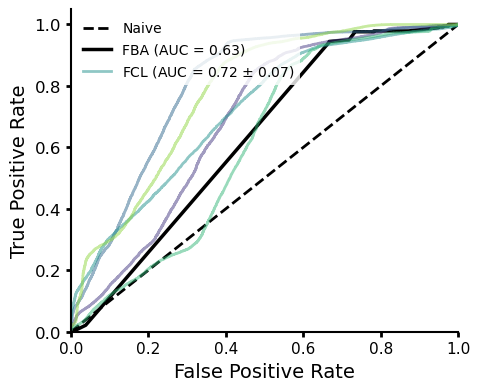

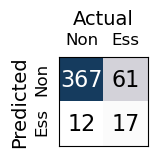

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import colormaps as cmaps
from matplotlib.colors import LinearSegmentedColormap
import sys
tools_path = './training/tools'
sys.path.append(tools_path)
import knockout_voting as ko

# Load data
data = pd.read_csv('fig3b_rf.csv')
fba_results = pd.read_csv('fig3b_fba.csv')
test_data = pd.read_csv('fig3b_test.csv')

# Plot ROC curves
fig, ax = plt.subplots(figsize=(5, 4.19))
colors = sns.color_palette("viridis", n_colors=5)

# Plot naive ROC curve
ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Naive')

# Plot FBA ROC curve
fpr, tpr, thresholds = roc_curve(fba_results.true_label, fba_results.score)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='black', lw=2.5, label=f'FBA (AUC = {roc_auc:.2f})')

# Plot ROC curves for each fold
aucs = []
for f in data.fold.unique():
    fold_data = data.loc[data.fold == f]
    fpr, tpr, thresholds = roc_curve(fold_data.true_label, fold_data.score)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, color=colors[f], lw=2, alpha=0.5)

plt.plot(0,0, color=colors[2], lw=2, alpha=0.5, label=fr'FCL (AUC = {np.mean(aucs):.2f} $\pm$ {np.std(aucs):.2f})')

# Format ROC plot
legend = ax.legend(fontsize=10, alignment='left', loc='upper left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_linewidth(0.0)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.xaxis.set_tick_params(width=2, labelsize=11)
ax.yaxis.set_tick_params(width=2, labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
plt.show()

# Plot confusion matrix
color1 = cmaps.lipari[30].colors
color2 = cmaps.lipari[75].colors
unicolor_colormap = LinearSegmentedColormap.from_list("custom_palette", ['white', color2, color1], N=256)

# Calculate average confusion matrix across folds
cfs = []
for f in range(5):
    fold_df = test_data.loc[test_data.fold == f]
    confusion_matrix = ko.knockout_confusion_matrix(fold_df, thresh=0.5)
    cfs.append(confusion_matrix)
confusion_matrix = np.round(np.mean(cfs, axis=0),0)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(1.68, 1.77))
cax = ax.matshow(confusion_matrix, cmap=unicolor_colormap)

# Add text annotations
for (i, j), val in np.ndenumerate(confusion_matrix):
    color = 'white' if i == 0 and j == 0 else 'black'
    ax.text(j, i, '{0:.0f}'.format(val), ha='center', va='center', color=color, fontsize=16)

# Format confusion matrix plot
ax.set_xticks([0, 1])
ax.set_yticks([0.75, -0.25])
ax.set_yticklabels(['Ess', 'Non'], rotation=90, fontsize=12)
ax.set_xticklabels(['Non', 'Ess'], fontsize=12)
ax.yaxis.set_tick_params(width=0, labelsize=12)
ax.xaxis.set_tick_params(width=0, labelsize=12)
ax.set_ylabel('Predicted', fontsize=14)
ax.set_title('Actual', fontsize=14)
fig.tight_layout()